In [24]:
%matplotlib inline
import sys
sys.path.append('C:/Users/User/github/Function/python/')
import eif as iso
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import copy
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
sns.set_style(style="whitegrid")
sns.set_color_codes()

In [25]:
def branch2num(branch, init_root=0):
    num = [init_root]
    for b in branch:
        if b == 'L':
            num.append(num[-1] * 2 + 1)
        if b == 'R':
            num.append(num[-1] * 2 + 2)
    return num

In [26]:
def gen_graph(branches, g = None, init_root = 0, pre = ''):
    num_branches = [branch2num(i, init_root) for i in branches]
    all_nodes = [j for branch in num_branches for j in branch]
    all_nodes = np.unique(all_nodes)
    all_nodes = all_nodes.tolist()
    if g is None:
        g=ig.Graph()
    for k in all_nodes : g.add_vertex(pre+str(k))
    t=[]
    for j in range(len(branches)):
        branch = branch2num(branches[j], init_root)
        for i in range(len(branch)-1):
            pair = [branch[i],branch[i+1]]
            if pair not in t:
                t.append(pair)
                g.add_edge(pre+str(branch[i]),pre+str(branch[i+1]))
    return g,max(all_nodes)

In [27]:
df_tr_1 = pd.read_csv("C:/Users/User/github/data/TFTLCD/ph1_bytime.csv", encoding='cp949')
df_ts_1 = pd.read_csv("C:/Users/User/github/data/TFTLCD/ph2_in.csv", encoding='cp949')
df_ts_2 = pd.read_csv("C:/Users/User/github/data/TFTLCD/ph2_out.csv", encoding='cp949')

In [28]:
df_tr = df_tr_1.replace('Normal', 0)
df_ts_1 = df_ts_1.replace('정상', 0)
df_ts_1 = df_ts_1.replace('이상', 1)
df_ts_2 = df_ts_2.replace('정상', 0)
df_ts_2 = df_ts_2.replace('이상', 1)

In [29]:
df_tr_1 = df_tr_1.rename(columns={'추가정보_정상.이상여부':'Normal/Abnormal'})
df_ts_1 = df_ts_1.rename(columns={'추가정보_정상.이상여부':'Normal/Abnormal'})
df_ts_2 = df_ts_2.rename(columns={'추가정보_정상.이상여부':'Normal/Abnormal'})

df_tr_1.set_index(['Normal/Abnormal', 'TIME_STAMP'], inplace=True)
df_ts_1.set_index(['Normal/Abnormal', 'TIME_STAMP'], inplace=True)
df_ts_2.set_index(['Normal/Abnormal', 'TIME_STAMP'], inplace=True)

In [30]:
df_tr = df_tr_1.iloc[:, 7:49] # train
df_ts = pd.concat([df_ts_1.iloc[:,7:49], df_ts_2.iloc[:,7:49]])

In [31]:
df_tr_x = df_tr.iloc[:,:-1]
df_ts_x = df_ts.iloc[:,:-1]

In [32]:
df_tr_x = df_tr_x.reset_index(drop = True)
df_tr_x = np.array(df_tr_x)
df_ts_x = df_ts_x.reset_index(drop = True)
df_ts_x = np.array(df_ts_x)

In [33]:
param_grid = {'ntrees' : [50,100,150,200,250], 'limit' : [5,6,7,8,9,10,11]}

In [34]:
grid = GridSearchCV(iso.iForest, param_grid=param_grid, cv = 5)

In [35]:
F0  = iso.iForest(df_tr_x, ntrees=500, limit=12, sample_size=256, ExtensionLevel=0) # ExtensionLevel=0 is the same as regular Isolation Forest
F1  = iso.iForest(df_tr_x, ntrees=500, limit=12, sample_size=256, ExtensionLevel=1)
F2  = iso.iForest(df_tr_x, ntrees=500, limit=12, sample_size=256, ExtensionLevel=2)

In [36]:
S0 = F0.compute_paths(X_in=df_ts_x)
S1 = F1.compute_paths(X_in=df_ts_x)
S2 = F2.compute_paths(X_in=df_ts_x)

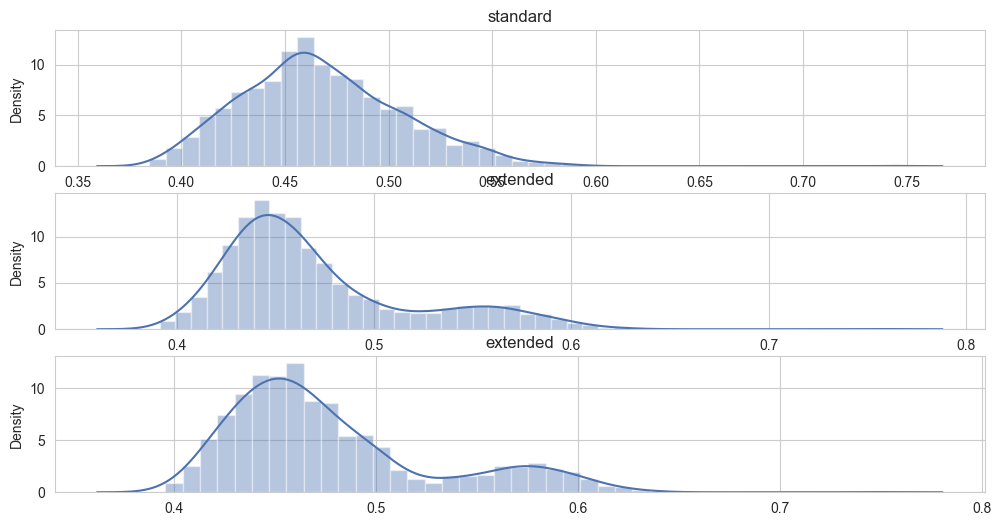

In [37]:
f = plt.figure(figsize=(12,6))

plt.subplot(3,1,1)
sns.distplot(S0, kde=True, color="b")
plt.title('standard')

plt.subplot(3,1,2)
sns.distplot(S1, kde=True, color="b")
plt.title('extended')

plt.subplot(3,1,3)
sns.distplot(S2, kde=True, color="b")
plt.title('extended')
plt.show()

In [38]:
test = pd.DataFrame(pd.concat([df_ts_1.reset_index(), df_ts_2.reset_index()], axis=0).iloc[:,50])

In [39]:
total1 = pd.concat([test.reset_index(drop=True),pd.DataFrame(S0).reset_index(drop = True)], axis = 1)
total2 = pd.concat([test.reset_index(drop=True),pd.DataFrame(S1).reset_index(drop = True)], axis = 1)
total3 = pd.concat([test.reset_index(drop=True),pd.DataFrame(S2).reset_index(drop = True)], axis = 1)

<AxesSubplot: ylabel='0'>

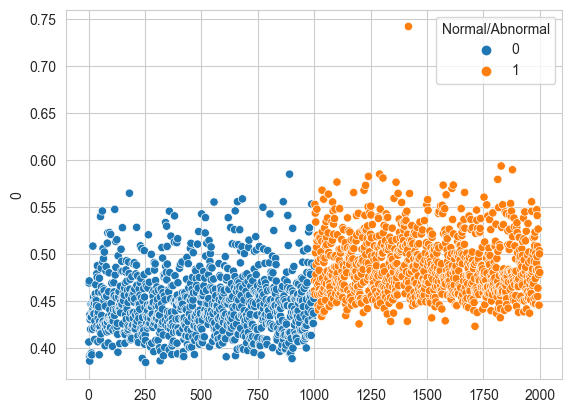

In [40]:
sns.scatterplot(data = total1, x = list(range(1,2001)), y = total1.iloc[:,1],
            hue='Normal/Abnormal')

<AxesSubplot: ylabel='0'>

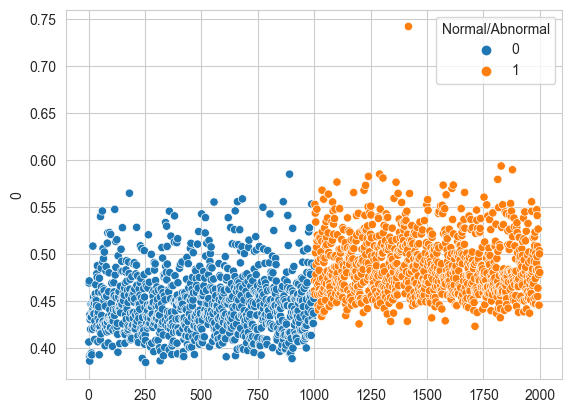

In [41]:
sns.scatterplot(data = total2, x = list(range(1,2001)), y = total1.iloc[:,1],
            hue='Normal/Abnormal')

<AxesSubplot: ylabel='0'>

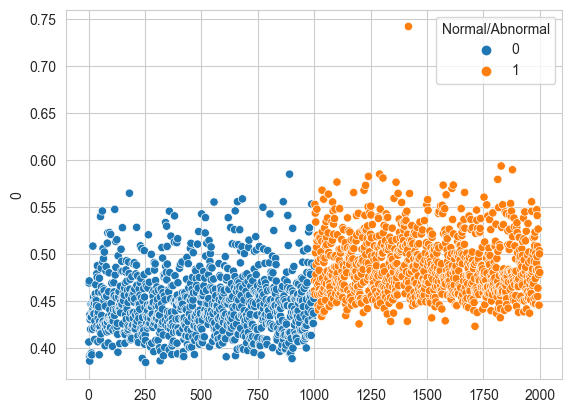

In [42]:
sns.scatterplot(data = total3, x = list(range(1,2001)), y = total1.iloc[:,1],
            hue='Normal/Abnormal')

In [43]:
total1_alpha = []
total1_beta = []
for i in range(1,100):
    i = i/100
    testline = i
    total1_alpha.append(np.array(np.where(total1.iloc[:1000,1] > testline)).size)
    total1_beta.append(np.array(np.where(total1.iloc[1000:,1] < testline)).size)

In [44]:
total2_alpha = []
total2_beta = []
for i in range(1,100):
    i = i/100
    testline = i
    total2_alpha.append(np.array(np.where(total2.iloc[:1000,1] > testline)).size)
    total2_beta.append(np.array(np.where(total2.iloc[1000:,1] < testline)).size)

In [45]:
total3_alpha = []
total3_beta = []
for i in range(1,100):
    i = i/100
    testline = i
    total3_alpha.append(np.array(np.where(total3.iloc[:1000,1] > testline)).size)
    total3_beta.append(np.array(np.where(total3.iloc[1000:,1] < testline)).size)

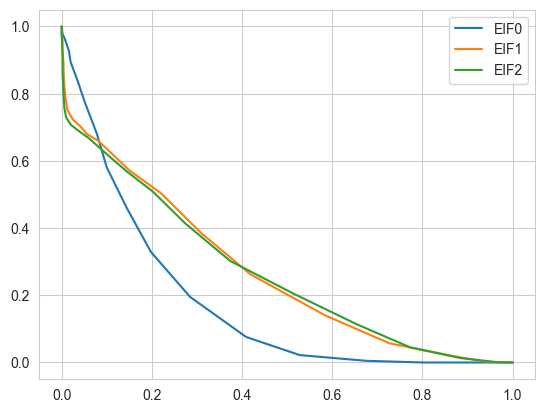

In [46]:
plt.plot(np.array(total1_alpha)/1000,np.array(total1_beta)/1000, label = 'EIF0')
plt.plot(np.array(total2_alpha)/1000,np.array(total2_beta)/1000, label = 'EIF1')
plt.plot(np.array(total3_alpha)/1000,np.array(total3_beta)/1000, label = 'EIF2')
plt.legend()
plt.show()

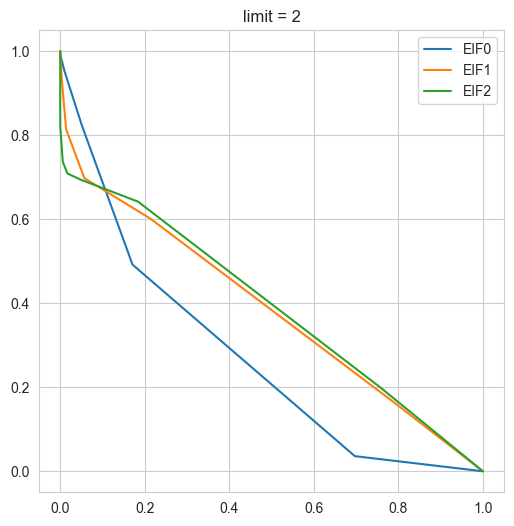

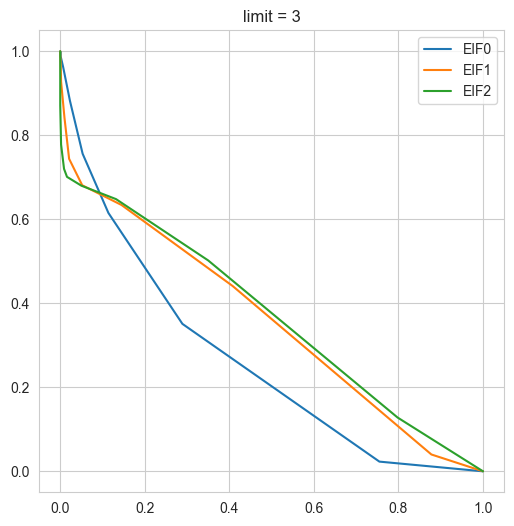

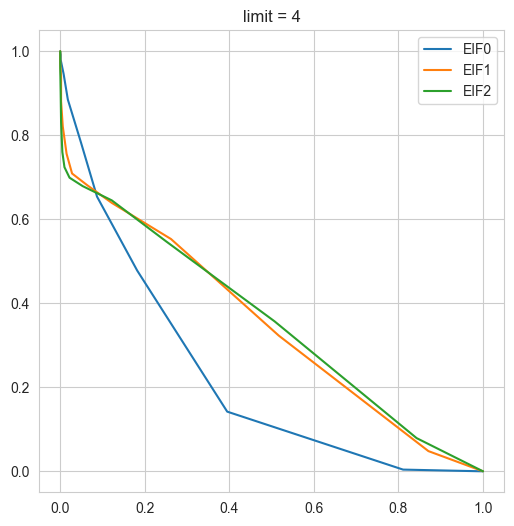

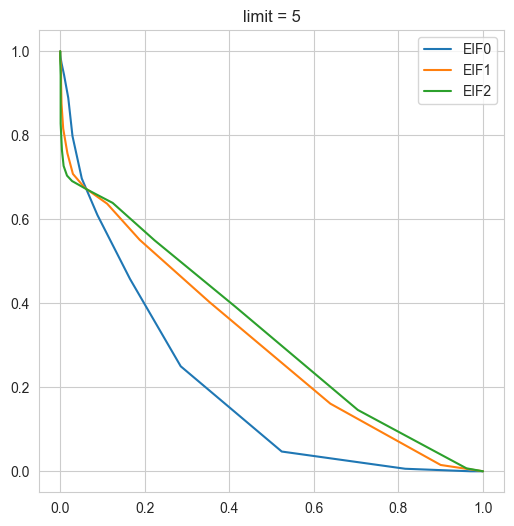

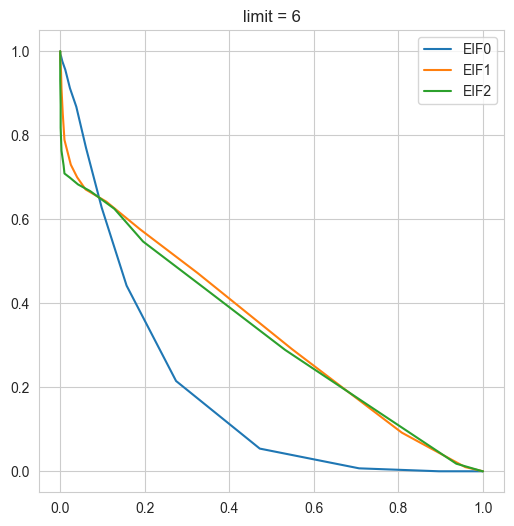

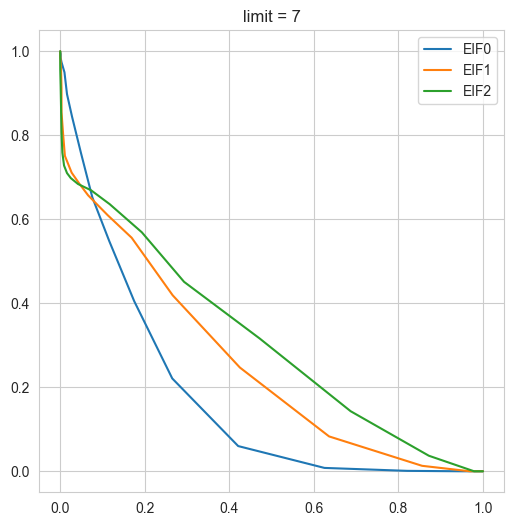

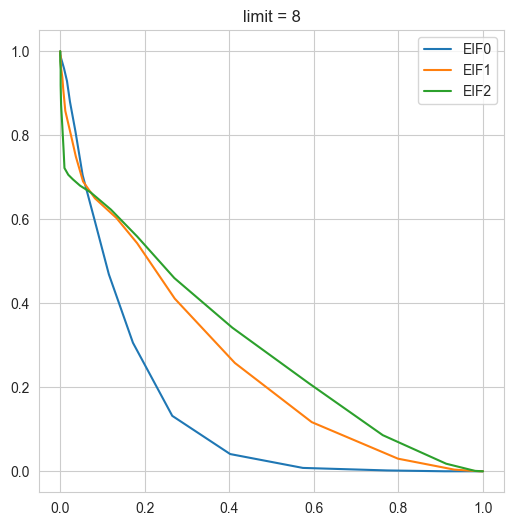

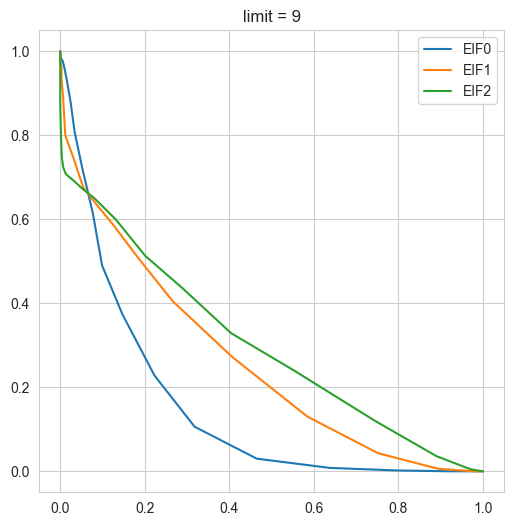

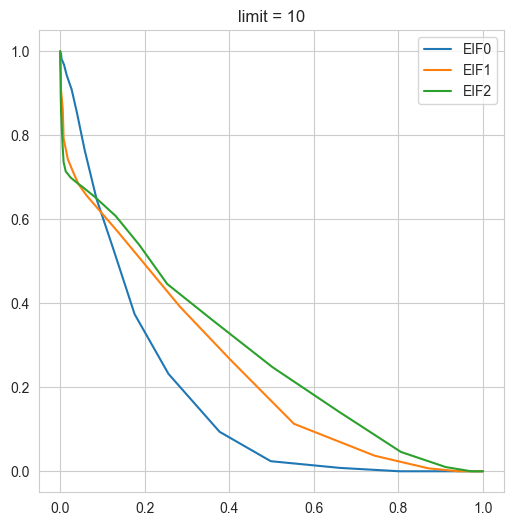

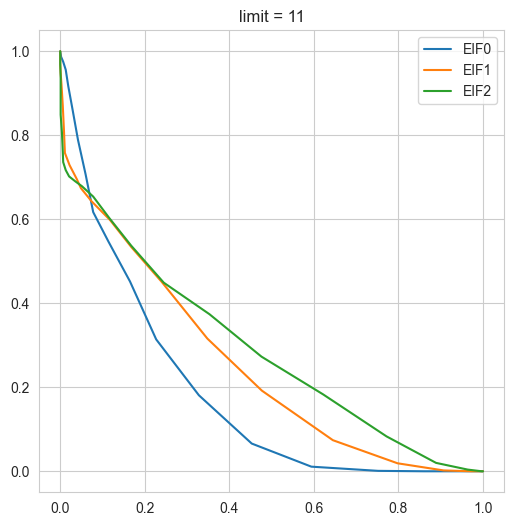

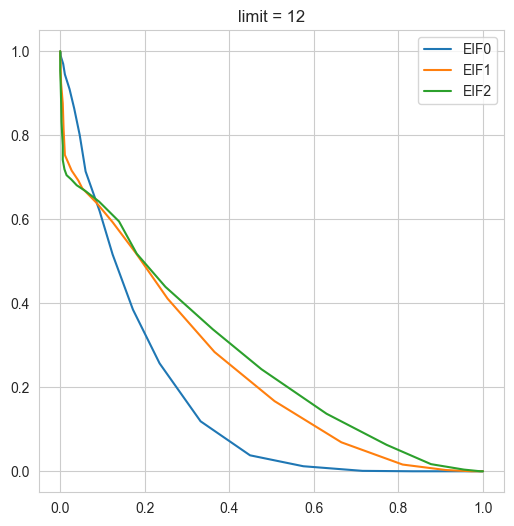

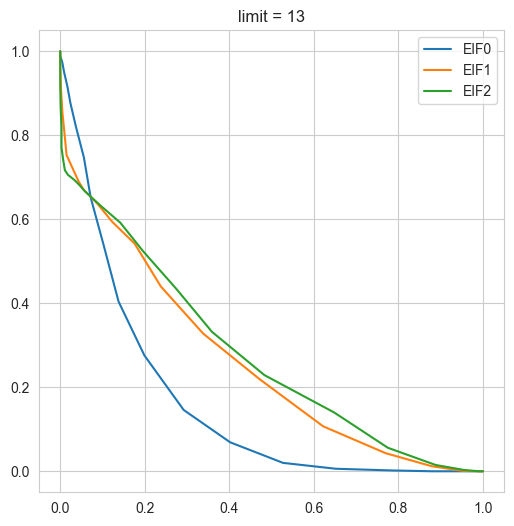

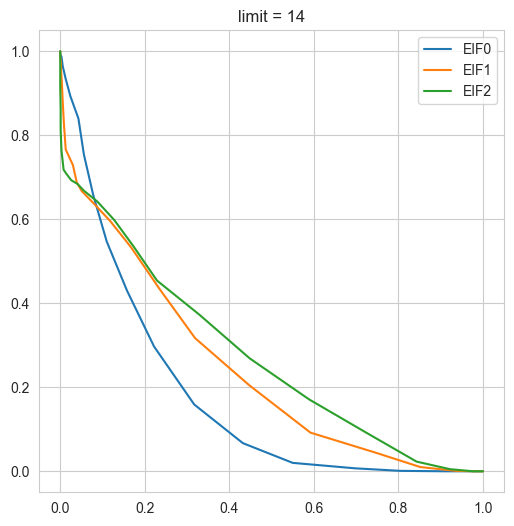

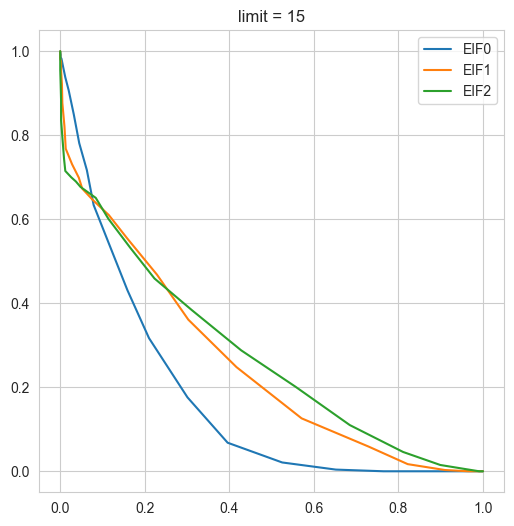

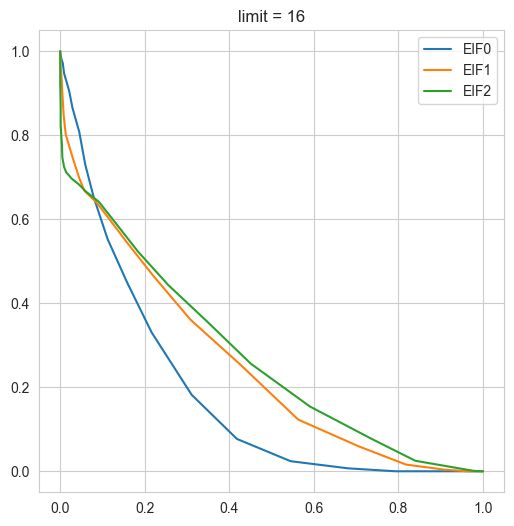

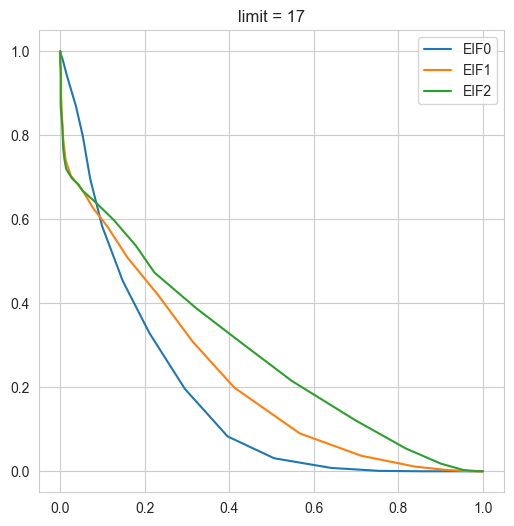

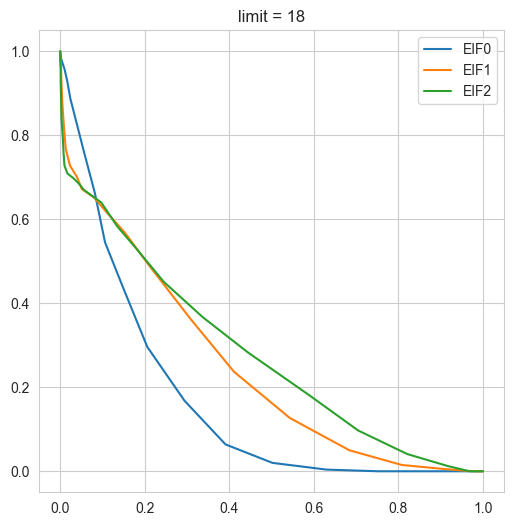

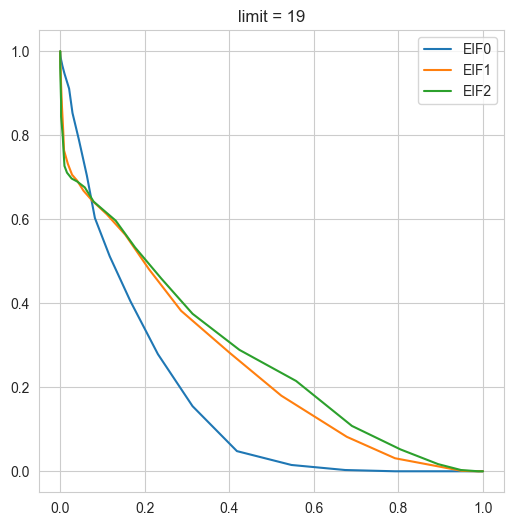

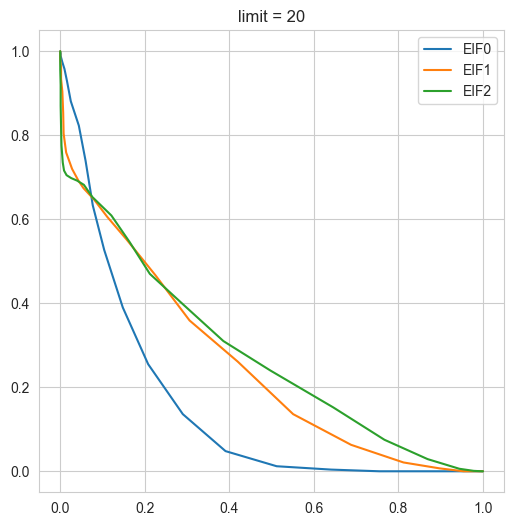

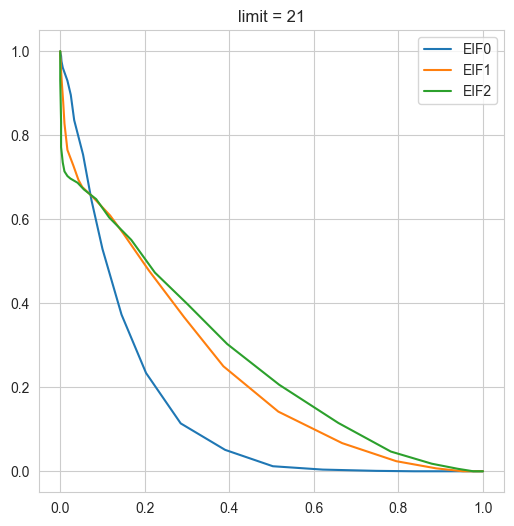

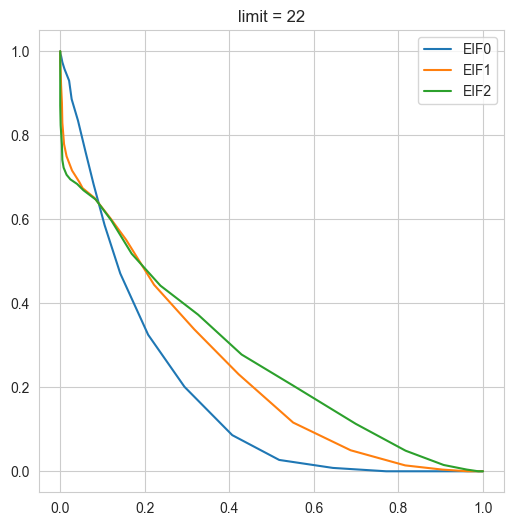

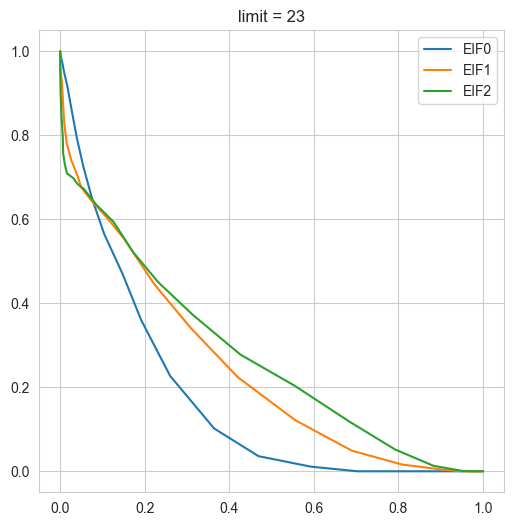

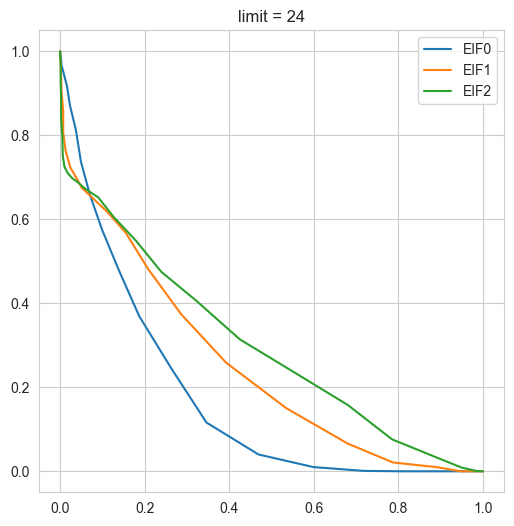

In [74]:
for k in range(2,25):
    F0  = iso.iForest(df_tr_x, ntrees=500, limit=k, sample_size=256, ExtensionLevel=0) # ExtensionLevel=0 is the same as regular Isolation Forest
    F1  = iso.iForest(df_tr_x, ntrees=500, limit=k, sample_size=256, ExtensionLevel=1)
    F2  = iso.iForest(df_tr_x, ntrees=500, limit=k, sample_size=256, ExtensionLevel=2)
    S0 = F0.compute_paths(X_in=df_ts_x)
    S1 = F1.compute_paths(X_in=df_ts_x)
    S2 = F2.compute_paths(X_in=df_ts_x)
    total1 = pd.concat([test.reset_index(drop=True),pd.DataFrame(S0).reset_index(drop = True)], axis = 1)
    total2 = pd.concat([test.reset_index(drop=True),pd.DataFrame(S1).reset_index(drop = True)], axis = 1)
    total3 = pd.concat([test.reset_index(drop=True),pd.DataFrame(S2).reset_index(drop = True)], axis = 1)

    total1_alpha = []
    total1_beta = []
    for i in range(1,100):
        i = i/100
        testline = i
        total1_alpha.append(np.array(np.where(total1.iloc[:1000,1] > testline)).size)
        total1_beta.append(np.array(np.where(total1.iloc[1000:,1] < testline)).size)

    total2_alpha = []
    total2_beta = []
    for i in range(1,100):
        i = i/100
        testline = i
        total2_alpha.append(np.array(np.where(total2.iloc[:1000,1] > testline)).size)
        total2_beta.append(np.array(np.where(total2.iloc[1000:,1] < testline)).size)

    total3_alpha = []
    total3_beta = []
    for i in range(1,100):
        i = i/100
        testline = i
        total3_alpha.append(np.array(np.where(total3.iloc[:1000,1] > testline)).size)
        total3_beta.append(np.array(np.where(total3.iloc[1000:,1] < testline)).size)

    #plt.subplot(k,1,1)
    plt.figure(figsize=(6,6))
    plt.title("limit = " + str(k))
    plt.plot(np.array(total1_alpha)/1000,np.array(total1_beta)/1000, label = 'EIF0')
    plt.plot(np.array(total2_alpha)/1000,np.array(total2_beta)/1000, label = 'EIF1')
    plt.plot(np.array(total3_alpha)/1000,np.array(total3_beta)/1000, label = 'EIF2')
    plt.legend()
    plt.show()